 This code demonstrates the process of training a contrastive learning model on the CIFAR-10 dataset using a pre-trained ResNet50 as the base network. The learned representations are then visualized using t-SNE to assess the quality of the embeddings and the separation of different classes in the embedding space.



1. Importing Libraries:
   - The code imports necessary libraries such as TensorFlow, Keras, NumPy, Matplotlib, and scikit-learn.

2. Preprocessing Data:
   - The CIFAR-10 dataset is loaded using `keras.datasets.cifar10.load_data()`.
   - The `preprocess_data` function normalizes the pixel values to the range [0, 1].

3. Data Augmentation:
   - A data augmentation pipeline is defined using `keras.Sequential()` to apply random flips, rotations, and zooms to the input images.

4. Creating the Base Model:
   - The `create_base_model` function defines a base model using the ResNet50 architecture with pre-trained ImageNet weights.
   - The top layer of the base model is removed, and global average pooling and a dense layer with 128 units are added.

5. Creating Pairs:
   - The `make_pairs` function creates positive and negative pairs of images for contrastive learning.
   - Positive pairs consist of images from the same class, while negative pairs consist of images from different classes.

6. Contrastive Loss Function:
   - The `contrastive_loss` function defines the contrastive loss used for training the model.
   - It encourages the embeddings of positive pairs to be close together and the embeddings of negative pairs to be far apart.

7. Building the Contrastive Learning Model:
   - The model takes two input images and processes them using the base network.
   - The distance between the embeddings of the two images is computed using the Euclidean distance.
   - The model is compiled with the contrastive loss function and Adam optimizer.

8. Training the Model:
   - The model is trained using the generated pairs of images and their corresponding labels.
   - The training is performed for 10 epochs with a batch size of 64.

9. Extracting Representations:
   - After training, the base network is used to extract representations (embeddings) for the test images.

10. t-SNE Visualization:
    - The t-SNE algorithm is used to reduce the dimensionality of the learned representations to 2D.
    - The t-SNE results are plotted using Matplotlib, with each point colored according to its true class label.



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 86s 43ms/step - accuracy: 0.5097 - loss: 0.2600 - val_accuracy: 0.5031 - val_loss: 0.2537
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 38ms/step - accuracy: 0.5107 - loss: 0.2515 - val_accuracy: 0.5096 - val_loss: 0.2510
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.5050 - loss: 0.2506 - val_accuracy: 0.5078 - val_loss: 0.2505
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - accuracy: 0.5058 - loss: 0.2503 - val_accuracy: 0.5051 - val_loss: 0.2501
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 38ms/step - accuracy: 0.5029 - loss: 0.2501 - val_accuracy: 0.5000 - val_loss: 0.2501
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - accuracy: 0.5023 - loss: 0.2500 - val_accuracy: 0.4981 - val_loss: 0.2493
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.4668 - loss: 0.2473 - val_accuracy

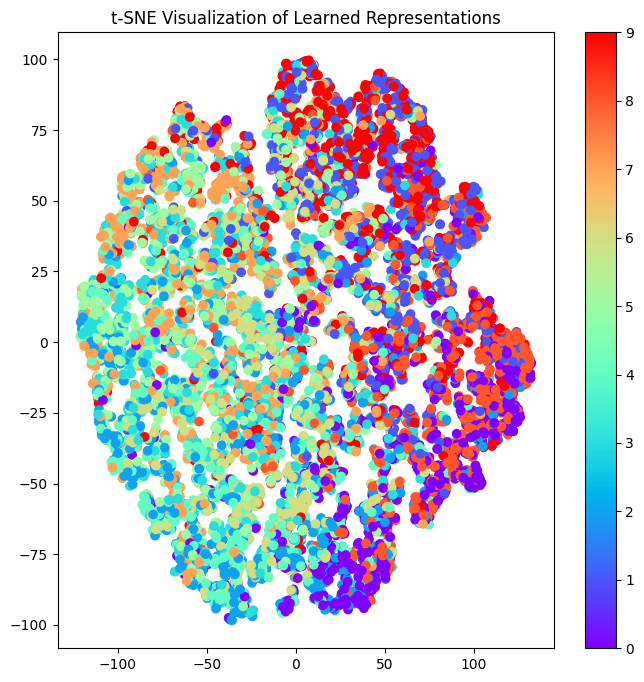

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def preprocess_data(x, y):
    x = x.astype("float32") / 255.0
    return x, y

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def create_base_model():
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(128, activation=None)(x)
    return keras.Model(inputs, outputs)

def make_pairs(images, labels):
    pair_images = []
    pair_labels = []
    labels = np.squeeze(labels)
    num_classes = np.max(labels) + 1
    idx = [np.where(labels == i)[0] for i in range(0, num_classes)]

    for idxA in range(len(images)):
        current_image = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        pos_image = images[idxB]
        pair_images.append([current_image, pos_image])
        pair_labels.append([1])
        neg_idx = np.where(labels != label)[0]
        neg_image = images[np.random.choice(neg_idx)]
        pair_images.append([current_image, neg_image])
        pair_labels.append([0])

    return np.array(pair_images), np.array(pair_labels)

pair_train, label_train = make_pairs(x_train, y_train.flatten())
pair_test, label_test = make_pairs(x_test, y_test.flatten())

base_network = create_base_model()

input_a = layers.Input(shape=(32, 32, 3))
input_b = layers.Input(shape=(32, 32, 3))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Adjusted contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32 to match y_pred
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

distance = layers.Lambda(lambda embeddings: tf.norm(embeddings[0] - embeddings[1], axis=1, keepdims=True))([processed_a, processed_b])
outputs = layers.Dense(1, activation="sigmoid")(distance)
model = keras.Model(inputs=[input_a, input_b], outputs=outputs)

model.compile(loss=contrastive_loss, optimizer="adam", metrics=["accuracy"])

history = model.fit([pair_train[:, 0], pair_train[:, 1]], label_train[:],
                    validation_data=([pair_test[:, 0], pair_test[:, 1]], label_test[:]),
                    batch_size=64, epochs=10)

# Extract representations
representations = base_network.predict(x_test)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, max_iter=3000)
tsne_results = tsne.fit_transform(representations)

plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test.flatten(), cmap='rainbow')
plt.title('t-SNE Visualization of Learned Representations')
plt.colorbar()
plt.show()

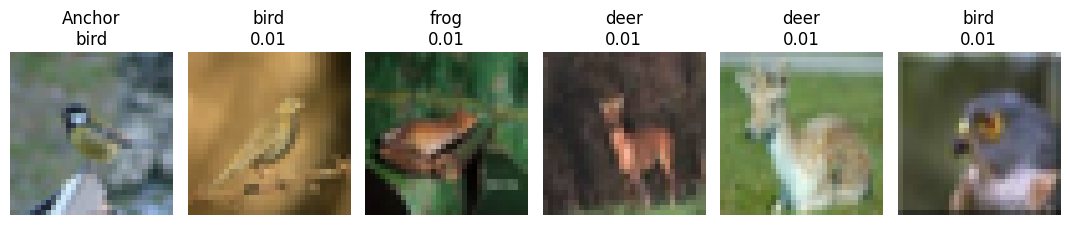

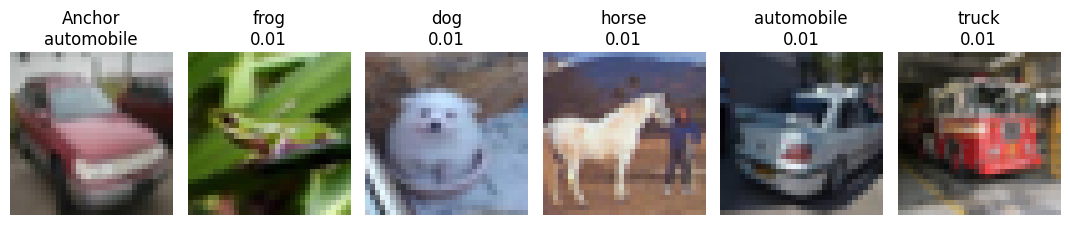

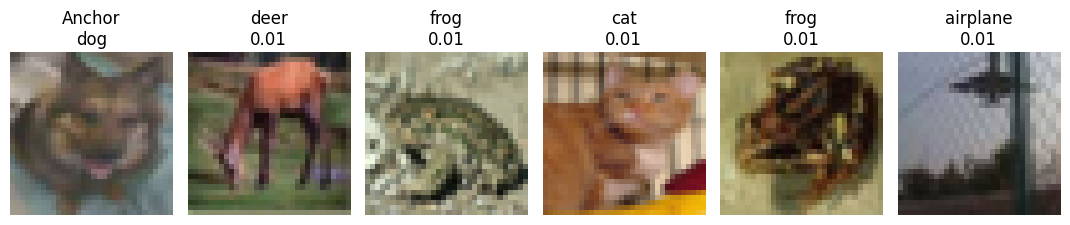

In [ ]:
# === CELL 1: retrieval gallery (with robust encoder patch) ===
import numpy as np, matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------- Patch: define `encoder` if missing, plus embedding helpers ----------
def _l2_norm(t, axis=1, eps=1e-10):
    return t / tf.maximum(tf.norm(t, axis=axis, keepdims=True), eps)

try:
    encoder  # does it exist?
except NameError:
    try:
        base_network
    except NameError as e:
        raise ValueError("Need either `encoder` or `base_network` defined before Cell A.") from e

    inp = keras.Input(shape=(32, 32, 3))
    h = base_network(inp, training=False)

    # Use GAP if we got a feature map; otherwise assume it is already flat.
    rank = len(h.shape) if hasattr(h, "shape") else None
    if rank == 4:
        x = layers.GlobalAveragePooling2D()(h)
    else:
        x = h

    emb = layers.Lambda(lambda t: _l2_norm(t, axis=1), name="emb_norm")(x)
    # Return [emb, emb] so "encoder(...)[0]" patterns still work.
    encoder = keras.Model(inp, [emb, emb], name="encoder_wrapper")

def get_embeddings(model, x, batch_size=512):
    y = model.predict(x, batch_size=batch_size, verbose=0)
    if isinstance(y, (list, tuple)):
        y = y[0]
    return np.asarray(y)

# ---------- Compute embeddings and build neighbor index ----------
emb_train = get_embeddings(encoder, x_train, batch_size=512)
emb_test  = get_embeddings(encoder, x_test,  batch_size=512)

nn = NearestNeighbors(n_neighbors=6, metric="euclidean").fit(emb_train)

CIFAR10_CLASSES = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def show_neighbors(test_index, K=5):
    anchor = x_test[test_index]
    label  = int(y_test.flatten()[test_index])
    dist, idx = nn.kneighbors(emb_test[test_index].reshape(1, -1), n_neighbors=K)
    idx = idx[0]; dist = dist[0]

    plt.figure(figsize=(1.8*(K+1), 2.2))
    plt.subplot(1, K+1, 1)
    plt.imshow(anchor); plt.axis("off")
    plt.title(f"Anchor\n{CIFAR10_CLASSES[label]}")
    for j in range(K):
        tj = x_train[idx[j]]
        lj = int(y_train.flatten()[idx[j]])
        plt.subplot(1, K+1, j+2)
        plt.imshow(tj); plt.axis("off")
        plt.title(f"{CIFAR10_CLASSES[lj]}\n{dist[j]:.2f}")
    plt.tight_layout()
    plt.show()

# Try a few random anchors
for i in np.random.choice(len(x_test), size=3, replace=False):
    show_neighbors(i, K=5)


Silhouette score (embeddings): -0.0890


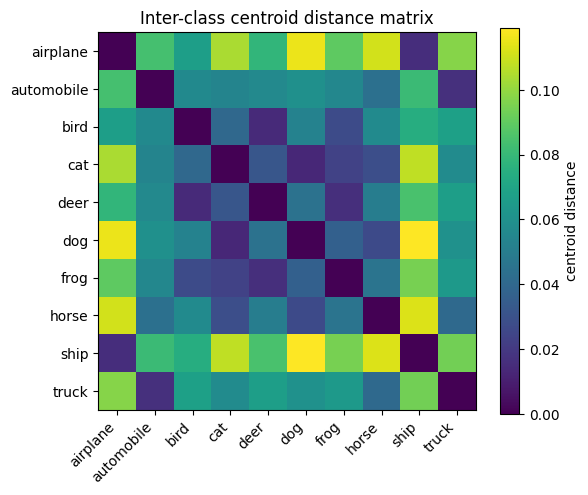

Avg intra-class distance per class:
  airplane: 0.062
automobile: 0.062
      bird: 0.057
       cat: 0.057
      deer: 0.050
       dog: 0.055
      frog: 0.049
     horse: 0.054
      ship: 0.061
     truck: 0.062

Mean intra: 0.057 | Mean inter: 0.061


In [ ]:
# === CELL 2: cluster compactness & separation ===
from sklearn.metrics import silhouette_score
import numpy as np, matplotlib.pyplot as plt

# Reuse embeddings from Cell A
X = np.concatenate([emb_train, emb_test], axis=0)
y = np.concatenate([y_train.flatten(), y_test.flatten()], axis=0)

# 1) Silhouette score (higher is better)
sil = silhouette_score(X, y, metric="euclidean")
print(f"Silhouette score (embeddings): {sil:.4f}")

# 2) Centroids + intra/inter distances
num_classes = 10
centroids, intra = [], []
for c in range(num_classes):
    Xc = X[y == c]
    mu = Xc.mean(axis=0, keepdims=True)
    centroids.append(mu)
    intra.append(np.mean(np.linalg.norm(Xc - mu, axis=1)))
centroids = np.vstack(centroids)

D = np.linalg.norm(centroids[:, None, :] - centroids[None, :, :], axis=2)

plt.figure(figsize=(6, 5))
plt.imshow(D, cmap="viridis")
plt.colorbar(label="centroid distance")
plt.xticks(range(num_classes), CIFAR10_CLASSES, rotation=45, ha="right")
plt.yticks(range(num_classes), CIFAR10_CLASSES)
plt.title("Inter-class centroid distance matrix")
plt.tight_layout(); plt.show()

print("Avg intra-class distance per class:")
for c in range(num_classes):
    print(f"{CIFAR10_CLASSES[c]:>10s}: {intra[c]:.3f}")
print(f"\nMean intra: {np.mean(intra):.3f} | Mean inter: {D[np.triu_indices(num_classes,1)].mean():.3f}")


In [ ]:
# === CELL 3: linear probe ===
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression(max_iter=2000, multi_class="multinomial", n_jobs=-1)
clf.fit(emb_train, y_train.flatten())
pred = clf.predict(emb_test)
acc = accuracy_score(y_test.flatten(), pred)
print(f"Linear Probe Accuracy (frozen embeddings): {acc:.4f}\n")
print(classification_report(y_test.flatten(), pred, target_names=CIFAR10_CLASSES))



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Linear Probe Accuracy (frozen embeddings): 0.3654

              precision    recall  f1-score   support

    airplane       0.42      0.46      0.44      1000
  automobile       0.38      0.32      0.35      1000
        bird       0.28      0.25      0.26      1000
         cat       0.21      0.04      0.06      1000
        deer       0.35      0.30      0.32      1000
         dog       0.33      0.43      0.38      1000
        frog       0.36      0.46      0.40      1000
       horse       0.35      0.45      0.39      1000
        ship       0.43      0.49      0.46      1000
       truck       0.40      0.46      0.43      1000

    accuracy                           0.37     10000
   macro avg       0.35      0.37      0.35     10000
weighted avg       0.35      0.37      0.35     10000



In [ ]:
# === CELL 4: SimCLR-style NT-Xent pretraining (encoder frozen) + probe ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1) Strong augmentations
aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomCrop(28, 28),
    layers.Resizing(32, 32),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    layers.GaussianNoise(0.05),
])

# 2) Projection head (on top of encoder embeddings)
proj_head = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(128, use_bias=False),
    layers.Lambda(lambda t: t / tf.maximum(tf.norm(t, axis=1, keepdims=True), 1e-10))
])

# 3) NT-Xent loss (InfoNCE)
@tf.function
def ntxent_loss(z1, z2, temperature=0.2):
    B = tf.shape(z1)[0]
    z = tf.concat([z1, z2], axis=0)               # (2B, D), already L2-normed
    sim = tf.matmul(z, z, transpose_b=True)       # cosine sim via dot
    # mask self-similarity
    sim = sim - 1e9 * tf.eye(2*B)
    # positives: i <-> B+i
    labels = tf.concat([tf.range(B, 2*B), tf.range(0, B)], axis=0)
    logits = sim / temperature
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    return loss

# Helper: get first output tensor from encoder without .predict
def emb_tensor(x, training=False):
    y = encoder(x, training=training)
    return y[0] if isinstance(y, (list, tuple)) else y

pre_opt = keras.optimizers.Adam(1e-3)

@tf.function
def pretrain_step(batch_x):
    with tf.GradientTape() as tape:
        x1 = aug(batch_x, training=True)
        x2 = aug(batch_x, training=True)
        e1 = emb_tensor(x1, training=False)
        e2 = emb_tensor(x2, training=False)
        z1 = proj_head(e1, training=True)
        z2 = proj_head(e2, training=True)
        loss = ntxent_loss(z1, z2, temperature=0.2)
    grads = tape.gradient(loss, proj_head.trainable_variables)  # keep encoder frozen here
    pre_opt.apply_gradients(zip(grads, proj_head.trainable_variables))
    return loss

# 4) Run a short pretrain loop
batch_size = 512
epochs = 3
num = x_train.shape[0]
print("Starting SimCLR-style pretraining (encoder frozen)...")
for ep in range(1, epochs+1):
    idx = np.random.permutation(num)
    losses = []
    for i in range(0, num, batch_size):
        j = min(i+batch_size, num)
        loss = pretrain_step(x_train[idx[i:j]])
        losses.append(float(loss))
    print(f"Epoch {ep}/{epochs} | NT-Xent loss: {np.mean(losses):.4f}")

# 5) Evaluate: linear probe on (a) raw encoder emb vs (b) projected z
emb_train_ss = get_embeddings(encoder, x_train, batch_size=512)
emb_test_ss  = get_embeddings(encoder, x_test,  batch_size=512)
z_train_ss = proj_head.predict(emb_train_ss, batch_size=1024, verbose=0)
z_test_ss  = proj_head.predict(emb_test_ss,  batch_size=1024, verbose=0)

probe1 = LogisticRegression(max_iter=2000, multi_class="multinomial", n_jobs=-1).fit(emb_train_ss, y_train.flatten())
probe2 = LogisticRegression(max_iter=2000, multi_class="multinomial", n_jobs=-1).fit(z_train_ss,   y_train.flatten())

acc1 = accuracy_score(y_test.flatten(), probe1.predict(emb_test_ss))
acc2 = accuracy_score(y_test.flatten(), probe2.predict(z_test_ss))
print(f"Linear Probe (encoder emb): {acc1:.4f}")
print(f"Linear Probe (proj_head z): {acc2:.4f}")


Starting SimCLR-style pretraining (encoder frozen)...
Epoch 1/3 | NT-Xent loss: 7.6001
Epoch 2/3 | NT-Xent loss: 6.9236
Epoch 3/3 | NT-Xent loss: 6.9219


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Linear Probe (encoder emb): 0.3654
Linear Probe (proj_head z): 0.3706


In [ ]:
# === CELL 5: Cosine LR with Warmup ===
import math, tensorflow as tf

class CosineWithWarmup(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr=1e-3, warmup_steps=500, total_steps=10000):
        super().__init__()
        self.base_lr = base_lr
        self.warmup = warmup_steps
        self.total = total_steps
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        return tf.cond(
            step < self.warmup,
            lambda: self.base_lr * (step / tf.maximum(1.0, tf.cast(self.warmup, tf.float32))),
            lambda: 0.5 * self.base_lr * (1.0 + tf.cos(
                math.pi * (step - self.warmup) / tf.maximum(1.0, (self.total - self.warmup))
            ))
        )

# Example use:
# steps_per_epoch = math.ceil(len(label_train)/256)
# lr_sched = CosineWithWarmup(base_lr=1e-3, warmup_steps=5*steps_per_epoch, total_steps=20*steps_per_epoch)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_sched)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


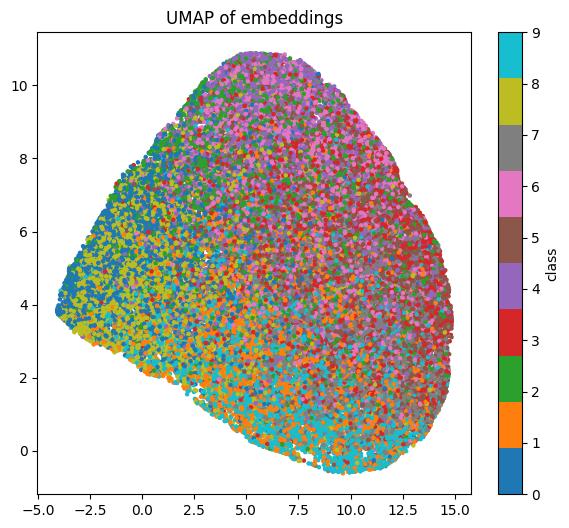

In [ ]:
# === CELL 6: UMAP visualization (optional) ===
# If needed in Colab: !pip -q install umap-learn
import numpy as np, matplotlib.pyplot as plt
try:
    import umap
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="euclidean", random_state=42)
    emb_all = np.concatenate([emb_train, emb_test], axis=0)
    y_all   = np.concatenate([y_train.flatten(), y_test.flatten()], axis=0)
    U = reducer.fit_transform(emb_all)
    plt.figure(figsize=(7,6))
    sc = plt.scatter(U[:,0], U[:,1], c=y_all, s=5, cmap="tab10")
    plt.title("UMAP of embeddings")
    plt.colorbar(sc, ticks=range(10), label="class")
    plt.show()
except Exception as e:
    print("UMAP not available:", e)
